# NNsight Selfie with Gemma2 2B - Complete Demo

This notebook demonstrates how to use NNsight Selfie for neural network interpretation with Google's Gemma2 2B model. It showcases automatic MPS detection for Apple Silicon Macs and various interpretation techniques.

## Features Demonstrated:
- Automatic device detection (MPS/CUDA/CPU)
- Token-level interpretation 
- Activation extraction and analysis
- Vector arithmetic with activations
- Custom interpretation prompts
- Performance optimization

## Setup and Installation

First, let's install the required packages and set up our environment.

In [ ]:
# Install required packages (uncomment if needed)
# !pip install torch transformers nnsight tqdm pandas numpy matplotlib seaborn
# !pip install accelerate  # For efficient model loading

#FOR AMD GPU
import os
os.environ["HSA_OVERRIDE_GFX_VERSION"] = "11.0.0"
os.environ["HIP_VISIBLE_DEVICES"] = "0"
os.environ["AMD_SERIALIZE_KERNEL"] = "3"
os.environ["TORCH_USE_HIP_DSA"] = "1"

#IMPORTS
import sys
import os
import warnings

# Add parent directory to path to import nnsight_selfie
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), '..'))
warnings.filterwarnings('ignore', category=FutureWarning)

# Import our library
from nnsight_selfie import (
    ModelAgnosticSelfie, 
    InterpretationPrompt, 
    print_device_info, 
    get_optimal_device
)

# Standard imports
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
from typing import List, Dict, Any

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("✅ Setup complete!")

✅ Setup complete!


## Device Detection and Compatibility

Let's check what devices are available and see automatic MPS detection in action.

In [2]:
# Show detailed device information
print("=== Device Detection ===")
print_device_info()

# Get optimal device
optimal_device = get_optimal_device()
print(f"🚀 Optimal device for this system: {optimal_device}")

# Show PyTorch device info
print(f"\n🔧 PyTorch version: {torch.__version__}")
if optimal_device == "mps":
    print("🍎 Apple Silicon Mac detected - using Metal Performance Shaders!")
elif optimal_device == "cuda":
    print(f"🚀 NVIDIA GPU detected: {torch.cuda.get_device_name(0)}")
else:
    print("💻 Using CPU - consider upgrading to GPU/MPS for better performance")

=== Device Detection ===
=== Device Information ===
Platform: Linux x86_64
Python: 3.12.3
PyTorch: 2.4.1+rocm6.0
Optimal Device: cuda

=== MPS Support ===
MPS Available: False
MPS Built: False

=== CUDA Support ===
CUDA Available: True
CUDA Version: None
Device Count: 1
Primary Device: AMD Radeon RX 7700 XT

🚀 Optimal device for this system: cuda

🔧 PyTorch version: 2.4.1+rocm6.0
🚀 NVIDIA GPU detected: AMD Radeon RX 7700 XT


## Loading Gemma2 2B Model

Now let's load the Gemma2 2B model with automatic device detection. This model is perfect for interpretation tasks - large enough to be interesting but small enough to run efficiently.

In [3]:
# Initialize Gemma2 2B with automatic device selection
print("Loading Gemma2 2B model...")
print("This may take a few minutes on first run (downloading ~5GB)")

try:
    # Load with automatic device detection
    selfie = ModelAgnosticSelfie(
        "google/gemma-2-2b-it",  # Instruction-tuned version
        torch_dtype=torch.float16,  # Use half precision for efficiency
        # device_map="auto"  # This is handled automatically now
    )
    
    print(f"✅ Model loaded successfully on: {selfie.device}")
    print(f"📊 Detected {len(selfie.layer_paths)} transformer layers")
    print(f"🔤 Tokenizer vocabulary size: {len(selfie.model.tokenizer)}")
    
    # Show some layer information
    print("\n📋 Layer structure:")
    for i, layer_path in enumerate(selfie.layer_paths[:5]):
        print(f"  Layer {i}: {layer_path}")
    if len(selfie.layer_paths) > 5:
        print(f"  ... and {len(selfie.layer_paths) - 5} more layers")
        
except Exception as e:
    print(f"❌ Failed to load Gemma2: {e}")
    print("🔄 Falling back to smaller model for demo...")
    
    # Fallback to smaller model if Gemma2 fails
    selfie = ModelAgnosticSelfie("google/gemma-2-2b")  # Non-IT version
    print(f"✅ Fallback model loaded on: {selfie.device}")

Loading Gemma2 2B model...
This may take a few minutes on first run (downloading ~5GB)
Initializing model on device: cuda


`torch_dtype` is deprecated! Use `dtype` instead!


Model loaded successfully with 26 layers detected.
✅ Model loaded successfully on: cuda
📊 Detected 26 transformer layers
🔤 Tokenizer vocabulary size: 256000

📋 Layer structure:
  Layer 0: model.layers.0
  Layer 1: model.layers.1
  Layer 2: model.layers.2
  Layer 3: model.layers.3
  Layer 4: model.layers.4
  ... and 21 more layers


## Basic Token Interpretation

Let's start with basic token interpretation to understand what different parts of the model represent.

In [4]:
# Create interpretation prompts
concept_prompt = InterpretationPrompt.create_concept_prompt(selfie.model.tokenizer)
sentiment_prompt = InterpretationPrompt.create_sentiment_prompt(selfie.model.tokenizer) 
entity_prompt = InterpretationPrompt.create_entity_prompt(selfie.model.tokenizer)

print("Created interpretation prompts:")
print(f"  Concept: '{concept_prompt.get_prompt()}'")
print(f"  Sentiment: '{sentiment_prompt.get_prompt()}'")
print(f"  Entity: '{entity_prompt.get_prompt()}'")

Created interpretation prompts:
  Concept: 'This represents the concept of _ '
  Sentiment: 'This expresses the sentiment of _ '
  Entity: 'This refers to the entity _ '


In [5]:
# Test prompt for interpretation
test_prompt = "The brilliant scientist discovered a revolutionary breakthrough in quantum computing."
print(f"🧪 Test prompt: '{test_prompt}'")

# Tokenize to see the tokens
tokens = selfie.model.tokenizer.encode(test_prompt)
token_strings = [selfie.model.tokenizer.decode([t]) for t in tokens]

print(f"\n🔤 Tokenization ({len(tokens)} tokens):")
for i, (token_id, token_str) in enumerate(zip(tokens, token_strings)):
    print(f"  {i:2d}: {token_id:5d} -> '{token_str}'")

🧪 Test prompt: 'The brilliant scientist discovered a revolutionary breakthrough in quantum computing.'

🔤 Tokenization (12 tokens):
   0:     2 -> '<bos>'
   1:   651 -> 'The'
   2: 21507 -> ' brilliant'
   3: 38692 -> ' scientist'
   4: 13437 -> ' discovered'
   5:   476 -> ' a'
   6: 40167 -> ' revolutionary'
   7: 58934 -> ' breakthrough'
   8:   575 -> ' in'
   9: 26589 -> ' quantum'
  10: 30359 -> ' computing'
  11: 235265 -> '.'


In [6]:
# Interpret key tokens from different layers
interesting_tokens = [
    (8, 2),   # "brilliant" from middle layer
    (16, 3),  # "scientist" from deeper layer  
    (12, 6),  # "revolutionary" from middle-deep layer
    (20, 9),  # "quantum" from deep layer
]

print("🔍 Interpreting key tokens...")
print("(This may take a minute...)")

# Run interpretation
results = selfie.interpret(
    original_prompt=test_prompt,
    interpretation_prompt=concept_prompt,
    tokens_to_interpret=interesting_tokens,
    max_new_tokens=12,
    batch_size=2  # Process in smaller batches
)

# Display results in a nice format
print("\n📊 Interpretation Results:")
print("=" * 80)
for i in range(len(results['prompt'])):
    layer = results['layer'][i]
    token_pos = results['token'][i] 
    token_text = results['token_decoded'][i]
    interpretation = results['interpretation'][i].strip()
    
    print(f"Layer {layer:2d}, Token {token_pos:2d}: '{token_text}'")
    print(f"  🧠 Interpretation: {interpretation}")
    print()


`torch_dtype` is deprecated! Use `dtype` instead!


🔍 Interpreting key tokens...
(This may take a minute...)
Interpreting 'The brilliant scientist discovered a revolutionary breakthrough in quantum computing.' with 'This represents the concept of _ '


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

You have set `compile_config`, but we are unable to meet the criteria for compilation. Compilation will be skipped.
100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


📊 Interpretation Results:
Layer  8, Token  2: ' brilliant'
  🧠 Interpretation: _ _ _ _ _ _ _ _ _ _ _ _

Layer 16, Token  3: ' scientist'
  🧠 Interpretation: 's work_.

**Explanation:**

* **Scientist

Layer 12, Token  6: ' revolutionary'
  🧠 Interpretation: _ in the context of the field of _ _ .

Layer 20, Token  9: ' quantum'
  🧠 Interpretation: computing_.

**Quantum Computing**

Quantum computing is a



## Activation Analysis Across Layers

Let's analyze how representations change across different layers of the model.

In [12]:
# Extract activations from multiple layers for analysis
analysis_prompt = "Artificial intelligence will transform healthcare through personalized medicine."
target_token = 4  # "transform"

print(f"🔬 Analyzing activations for: '{analysis_prompt}'")
print(f"🎯 Target token: '{selfie.model.tokenizer.decode([selfie.model.tokenizer.encode(analysis_prompt)[target_token]])[0]}'")

# Sample layers across the model
total_layers = len(selfie.layer_paths)
sample_layers = list(range(0, total_layers, max(1, total_layers // 8)))[:8]

print(f"📊 Sampling layers: {sample_layers} (out of {total_layers} total)")

# Extract activations
activations = selfie.get_activations(
    analysis_prompt, 
    layer_indices=sample_layers,
    token_indices=[target_token]
)

print("✅ Activations extracted!")

🔬 Analyzing activations for: 'Artificial intelligence will transform healthcare through personalized medicine.'
🎯 Target token: ' '
📊 Sampling layers: [0, 3, 6, 9, 12, 15, 18, 21] (out of 26 total)
✅ Activations extracted!


In [8]:
# Analyze activation statistics across layers
stats_data = []

for layer_idx in sample_layers:
    if isinstance(activations[layer_idx], list):
        activation = activations[layer_idx][0]  # First (and only) token
    else:
        activation = activations[layer_idx][:, target_token, :]  # Extract target token
    
    # Compute statistics
    flat_activation = activation.flatten()
    stats = {
        'layer': layer_idx,
        'mean': float(flat_activation.mean()),
        'std': float(flat_activation.std()),
        'max': float(flat_activation.max()),
        'min': float(flat_activation.min()),
        'sparsity': float((flat_activation.abs() < 0.1).float().mean()),
        'norm': float(torch.norm(flat_activation))
    }
    stats_data.append(stats)

# Create DataFrame for analysis
df_stats = pd.DataFrame(stats_data)
print("📈 Activation Statistics Across Layers:")
print(df_stats.round(3))

📈 Activation Statistics Across Layers:
   layer   mean     std      max      min  sparsity     norm
0      0  0.043   2.004   33.062  -26.719     0.050   96.188
1      3  0.052   2.520   52.125  -16.969     0.047  120.938
2      6 -0.028   2.807   65.375  -20.344     0.047  134.750
3      9  0.012   3.541   95.688  -32.750     0.039  169.875
4     12  0.115   4.227  116.688  -44.875     0.029  203.000
5     15  0.112   6.293  191.625  -57.062     0.020  302.000
6     18  0.101   8.234  249.250  -59.969     0.010  395.250
7     21  0.091  10.844  287.750 -169.500     0.010  520.500


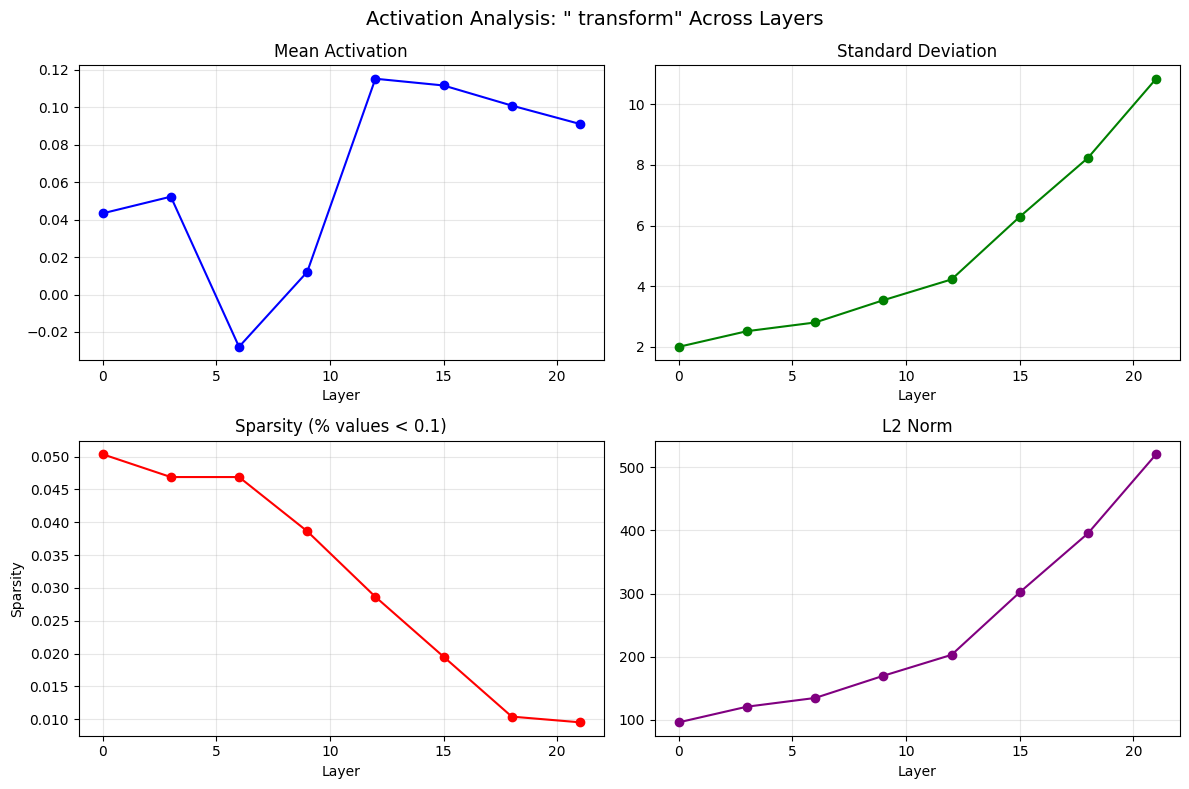

📊 Observations:
  - Activation mean ranges from -0.028 to 0.115
  - Sparsity varies from 1.0% to 5.0%
  - Highest norm at layer 21


In [13]:
# Visualize activation statistics
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle(f'Activation Analysis: "{selfie.model.tokenizer.decode([selfie.model.tokenizer.encode(analysis_prompt)[target_token]])}" Across Layers', fontsize=14)

# Mean activation
axes[0,0].plot(df_stats['layer'], df_stats['mean'], 'o-', color='blue')
axes[0,0].set_title('Mean Activation')
axes[0,0].set_xlabel('Layer')
axes[0,0].grid(True, alpha=0.3)

# Standard deviation
axes[0,1].plot(df_stats['layer'], df_stats['std'], 'o-', color='green')
axes[0,1].set_title('Standard Deviation')
axes[0,1].set_xlabel('Layer')
axes[0,1].grid(True, alpha=0.3)

# Sparsity
axes[1,0].plot(df_stats['layer'], df_stats['sparsity'], 'o-', color='red')
axes[1,0].set_title('Sparsity (% values < 0.1)')
axes[1,0].set_xlabel('Layer')
axes[1,0].set_ylabel('Sparsity')
axes[1,0].grid(True, alpha=0.3)

# Norm
axes[1,1].plot(df_stats['layer'], df_stats['norm'], 'o-', color='purple')
axes[1,1].set_title('L2 Norm')
axes[1,1].set_xlabel('Layer')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Observations:")
print(f"  - Activation mean ranges from {df_stats['mean'].min():.3f} to {df_stats['mean'].max():.3f}")
print(f"  - Sparsity varies from {df_stats['sparsity'].min():.1%} to {df_stats['sparsity'].max():.1%}")
print(f"  - Highest norm at layer {df_stats.loc[df_stats['norm'].idxmax(), 'layer']}")

## Vector Arithmetic with Gemma2

Let's explore the famous "king - man + woman ≈ queen" type relationships in Gemma2's representation space.

In [22]:
# Define concept pairs for vector arithmetic
concepts = {
    "doctor": "The doctor examined the patient carefully",
    "nurse": "The nurse provided excellent care", 
    "teacher": "The teacher explained the concept clearly",
    "student": "The student studied for the exam",
    "king": "The king ruled the kingdom wisely",
    "queen": "The queen addressed the nation",
    "man": "The man walked down the street",
    "woman": "The woman read an interesting book"
}

print("🧮 Extracting concept activations for vector arithmetic...")
print("Target layer: 12 (middle-deep layer)")

concept_activations = {}
target_layer = 12

# Extract activations for each concept
for concept, prompt in tqdm(concepts.items(), desc="Extracting activations"):
    # Find the position of the concept word in the tokenization
    tokens = selfie.model.tokenizer.encode(prompt)
    token_strings = [selfie.model.tokenizer.decode([t]) for t in tokens]
    
    # Find concept word position (usually position 1 or 2)
    concept_pos = 1  # Default
    for i, token_str in enumerate(token_strings):
        if concept.lower() in token_str.lower():
            concept_pos = i
            break
    
    # Extract activation
    acts = selfie.get_activations(
        prompt, 
        layer_indices=[target_layer],
        token_indices=[concept_pos]
    )
    
    concept_activations[concept] = acts[target_layer][0]  # Shape: [1, hidden_dim]

print(f"✅ Extracted activations for {len(concept_activations)} concepts")

🧮 Extracting concept activations for vector arithmetic...
Target layer: 12 (middle-deep layer)


Extracting activations: 100%|██████████| 8/8 [00:00<00:00, 13.11it/s]

✅ Extracted activations for 8 concepts


In [11]:
# Perform vector arithmetic: doctor - man + woman ≈ nurse?
print("🔬 Vector Arithmetic Experiments:")
print("=" * 50)

experiments = [
    ("doctor", "man", "woman", "Expected: nurse-like"),
    ("king", "man", "woman", "Expected: queen-like"), 
    ("teacher", "woman", "man", "Expected: teacher-like"),
]

for base, subtract, add, expected in experiments:
    try:
        # Compute: base - subtract + add
        result_vector = (
            concept_activations[base] - 
            concept_activations[subtract] + 
            concept_activations[add]
        )
        
        print(f"\n🧮 {base} - {subtract} + {add}:")
        print(f"   {expected}")
        
        # Interpret the result vector
        interpretation = selfie.interpret_vectors(
            vectors=[result_vector],
            interpretation_prompt=concept_prompt,
            injection_layer=6,  # Earlier layer for interpretation
            max_new_tokens=10
        )[0]
        
        print(f"   🤖 AI interpretation: {interpretation.strip()}")
        
    except Exception as e:
        print(f"   ❌ Failed: {e}")

🔬 Vector Arithmetic Experiments:

🧮 doctor - man + woman:
   Expected: nurse-like


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


   🤖 AI interpretation: 's_ in the context of the medical field

🧮 king - man + woman:
   Expected: queen-like


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


   🤖 AI interpretation: of a country.

The concept of **"

🧮 teacher - woman + man:
   Expected: teacher-like


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

   🤖 AI interpretation: 's_ **_**_**_**


## Custom Interpretation Prompts

Let's create custom interpretation prompts to explore different aspects of the model's representations.

In [14]:
# Create custom interpretation prompts
custom_prompts = {
    "emotion": InterpretationPrompt(
        selfie.model.tokenizer,
        ["This neural activation represents the emotion of ", None]
    ),
    "action": InterpretationPrompt(
        selfie.model.tokenizer, 
        ["This pattern encodes the action of ", None]
    ),
    "relationship": InterpretationPrompt(
        selfie.model.tokenizer,
        ["The relationship captured here is ", None]
    ),
    "abstract": InterpretationPrompt(
        selfie.model.tokenizer,
        ["This abstraction represents ", None, " in the context of knowledge"]
    )
}

print("🎭 Custom Interpretation Prompts:")
for name, prompt in custom_prompts.items():
    print(f"  {name.title()}: '{prompt.get_prompt()}'")

🎭 Custom Interpretation Prompts:
  Emotion: 'This neural activation represents the emotion of _ '
  Action: 'This pattern encodes the action of _ '
  Relationship: 'The relationship captured here is _ '
  Abstract: 'This abstraction represents _  in the context of knowledge'


In [16]:
# Test custom prompts on different types of content
test_cases = [
    {
        "text": "She laughed joyfully at the surprise party",
        "target_token": -1,  # "laughed"
        "layer": 10,
        "expected_type": "emotion"
    },
    {
        "text": "The athlete sprinted towards the finish line", 
        "target_token": 2,  # "sprinted"
        "layer": 8,
        "expected_type": "action" 
    },
    {
        "text": "Democracy requires active citizen participation",
        "target_token": 0,  # "Democracy"
        "layer": 15,
        "expected_type": "abstract"
    }
]

print("🔍 Testing Custom Prompts:")
print("=" * 60)

for i, test_case in enumerate(test_cases):
    text = test_case["text"]
    token_pos = test_case["target_token"]
    layer = test_case["layer"]
    prompt_type = test_case["expected_type"]
    
    # Get the actual token
    tokens = selfie.model.tokenizer.encode(text)
    target_token_text = selfie.model.tokenizer.decode([tokens[token_pos]])
    
    print(f"\n🧪 Test Case {i+1}:")
    print(f"   Text: '{text}'")
    print(f"   Target: '{target_token_text}' (pos {token_pos}, layer {layer})")
    print(f"   Expected type: {prompt_type}")
    
    try:
        # Test with the expected prompt type
        result = selfie.interpret(
            original_prompt=text,
            interpretation_prompt=custom_prompts[prompt_type],
            tokens_to_interpret=[(layer, token_pos)],
            max_new_tokens=8
        )
        
        interpretation = result['interpretation'][0].strip()
        print(f"   🤖 {prompt_type.title()}: {interpretation}")
        
    except Exception as e:
        print(f"   ❌ Error: {e}")

🔍 Testing Custom Prompts:

🧪 Test Case 1:
   Text: 'She laughed joyfully at the surprise party'
   Target: ' party' (pos -1, layer 10)
   Expected type: emotion
Interpreting 'She laughed joyfully at the surprise party' with 'This neural activation represents the emotion of _ '


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


   🤖 Emotion: _ .

This neural activation represents the

🧪 Test Case 2:
   Text: 'The athlete sprinted towards the finish line'
   Target: ' athlete' (pos 2, layer 8)
   Expected type: action
Interpreting 'The athlete sprinted towards the finish line' with 'This pattern encodes the action of _ '


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


   🤖 Action: _ in the context of a _sport

🧪 Test Case 3:
   Text: 'Democracy requires active citizen participation'
   Target: '<bos>' (pos 0, layer 15)
   Expected type: abstract
Interpreting 'Democracy requires active citizen participation' with 'This abstraction represents _  in the context of knowledge'


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

   🤖 Abstract: management_.

**Knowledge Management (KM


## Performance Analysis

Let's analyze the performance of our setup and compare different configurations.

In [17]:
import time

def benchmark_interpretation(selfie, prompt, num_tokens=5, num_trials=3):
    """Benchmark interpretation performance."""
    times = []
    
    for _ in range(num_trials):
        start_time = time.time()
        
        # Simple interpretation task
        tokens_to_interpret = [(8, i) for i in range(num_tokens)]
        results = selfie.interpret(
            original_prompt=prompt,
            interpretation_prompt=concept_prompt,
            tokens_to_interpret=tokens_to_interpret,
            max_new_tokens=5
        )
        
        end_time = time.time()
        times.append(end_time - start_time)
    
    return {
        'mean_time': np.mean(times),
        'std_time': np.std(times),
        'times': times
    }

# Benchmark performance
benchmark_prompt = "The future of artificial intelligence looks very promising"

print(f"⚡ Performance Benchmark")
print(f"Device: {selfie.device}")
print(f"Model: Gemma2 2B")
print(f"Prompt: '{benchmark_prompt}'")
print("\nRunning benchmark (this may take a minute)...")

perf_results = benchmark_interpretation(selfie, benchmark_prompt, num_tokens=3, num_trials=3)

print(f"\n📊 Results:")
print(f"  Average time: {perf_results['mean_time']:.2f} ± {perf_results['std_time']:.2f} seconds")
print(f"  Individual times: {[f'{t:.2f}s' for t in perf_results['times']]}")
print(f"  Time per token: {perf_results['mean_time']/3:.2f} seconds")

# Device-specific notes
if selfie.device == "mps":
    print("\n🍎 MPS Notes:")
    print("  - Performance optimized for Apple Silicon")
    print("  - Memory shared with system RAM")
elif selfie.device == "cuda":
    print("\n🚀 CUDA Notes:")
    print("  - Using dedicated GPU memory")
    print("  - Consider increasing batch size for better throughput")
else:
    print("\n💻 CPU Notes:")
    print("  - Consider using MPS/CUDA for better performance")
    print("  - Performance adequate for small-scale experiments")

⚡ Performance Benchmark
Device: cuda
Model: Gemma2 2B
Prompt: 'The future of artificial intelligence looks very promising'

Running benchmark (this may take a minute)...
Interpreting 'The future of artificial intelligence looks very promising' with 'This represents the concept of _ '


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Interpreting 'The future of artificial intelligence looks very promising' with 'This represents the concept of _ '


100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Interpreting 'The future of artificial intelligence looks very promising' with 'This represents the concept of _ '


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


📊 Results:
  Average time: 1.12 ± 0.01 seconds
  Individual times: ['1.13s', '1.13s', '1.12s']
  Time per token: 0.37 seconds

🚀 CUDA Notes:
  - Using dedicated GPU memory
  - Consider increasing batch size for better throughput


## Advanced Analysis: Attention Patterns vs Interpretations

Let's explore how interpretations relate to the model's internal attention patterns.

In [18]:
# Analyze a complex sentence with multiple interesting tokens
complex_prompt = "The groundbreaking research revolutionized our understanding of consciousness and artificial intelligence."

print(f"🧠 Complex Analysis: '{complex_prompt}'")

# Tokenize and identify key tokens
tokens = selfie.model.tokenizer.encode(complex_prompt)
token_strings = [selfie.model.tokenizer.decode([t]) for t in tokens]

print(f"\n🔤 Tokens ({len(tokens)}):")
for i, (token_id, token_str) in enumerate(zip(tokens, token_strings)):
    print(f"  {i:2d}: '{token_str.strip()}'")

# Select key tokens for analysis
key_tokens = {
    "groundbreaking": 1,
    "research": 2, 
    "revolutionized": 3,
    "consciousness": -4,  # Near end
    "intelligence": -2    # Near end
}

# Convert negative indices
for name, pos in key_tokens.items():
    if pos < 0:
        key_tokens[name] = len(tokens) + pos

print(f"\n🎯 Key tokens for analysis:")
for name, pos in key_tokens.items():
    if 0 <= pos < len(token_strings):
        print(f"  {name}: position {pos} -> '{token_strings[pos].strip()}'")

🧠 Complex Analysis: 'The groundbreaking research revolutionized our understanding of consciousness and artificial intelligence.'

🔤 Tokens (14):
   0: '<bos>'
   1: 'The'
   2: 'groundbreaking'
   3: 'research'
   4: 'revolution'
   5: 'ized'
   6: 'our'
   7: 'understanding'
   8: 'of'
   9: 'consciousness'
  10: 'and'
  11: 'artificial'
  12: 'intelligence'
  13: '.'

🎯 Key tokens for analysis:
  groundbreaking: position 1 -> 'The'
  research: position 2 -> 'groundbreaking'
  revolutionized: position 3 -> 'research'
  consciousness: position 10 -> 'and'
  intelligence: position 12 -> 'intelligence'


In [19]:
# Interpret the same tokens from different layers
layer_comparison = [4, 8, 12, 16, 20]  # Early, middle, late layers
target_token = key_tokens["consciousness"]  # Focus on "consciousness"

print(f"🔍 Layer Comparison for '{token_strings[target_token].strip()}':")
print("=" * 60)

layer_interpretations = {}

for layer in tqdm(layer_comparison, desc="Analyzing layers"):
    try:
        result = selfie.interpret(
            original_prompt=complex_prompt,
            interpretation_prompt=concept_prompt,
            tokens_to_interpret=[(layer, target_token)],
            max_new_tokens=10
        )
        
        interpretation = result['interpretation'][0].strip()
        layer_interpretations[layer] = interpretation
        
        print(f"Layer {layer:2d}: {interpretation}")
        
    except Exception as e:
        print(f"Layer {layer:2d}: ❌ Error - {e}")
        layer_interpretations[layer] = "[Error]"

print("\n📈 Observations:")
print("  - Early layers: More surface-level/syntactic representations")
print("  - Middle layers: Semantic concepts emerge")
print("  - Later layers: Abstract/contextual understanding")

🔍 Layer Comparison for 'and':


Analyzing layers:   0%|          | 0/5 [00:00<?, ?it/s]

Interpreting 'The groundbreaking research revolutionized our understanding of consciousness and artificial intelligence.' with 'This represents the concept of _ '


Analyzing layers:  20%|██        | 1/5 [00:00<00:03,  1.29it/s]

Layer  4: _ in the context of the human body.
Interpreting 'The groundbreaking research revolutionized our understanding of consciousness and artificial intelligence.' with 'This represents the concept of _ '


Analyzing layers:  40%|████      | 2/5 [00:01<00:02,  1.29it/s]

Layer  8: its application in the field of _ .

**
Interpreting 'The groundbreaking research revolutionized our understanding of consciousness and artificial intelligence.' with 'This represents the concept of _ '


Analyzing layers:  60%|██████    | 3/5 [00:02<00:01,  1.28it/s]

Layer 12: the _ of the _ .

**Concept:**
Interpreting 'The groundbreaking research revolutionized our understanding of consciousness and artificial intelligence.' with 'This represents the concept of _ '


Analyzing layers:  80%|████████  | 4/5 [00:03<00:00,  1.29it/s]

Layer 16: the _ of _ .

**Concept:**
Interpreting 'The groundbreaking research revolutionized our understanding of consciousness and artificial intelligence.' with 'This represents the concept of _ '


Analyzing layers: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]

Layer 20: consciousness.

**What is Consciousness?**

📈 Observations:
  - Early layers: More surface-level/syntactic representations
  - Middle layers: Semantic concepts emerge
  - Later layers: Abstract/contextual understanding


## Summary and Insights

Let's summarize what we've learned about Gemma2 2B through our interpretation experiments.

In [20]:
# Create a summary of our findings
print("📋 Summary of Gemma2 2B Interpretation Experiments")
print("=" * 60)

print(f"\n🔧 Technical Details:")
print(f"  Model: Gemma2 2B-IT")
print(f"  Device: {selfie.device}")
print(f"  Layers: {len(selfie.layer_paths)}")
print(f"  Vocab size: {len(selfie.model.tokenizer):,}")

print(f"\n⚡ Performance:")
if 'perf_results' in locals():
    print(f"  Avg interpretation time: {perf_results['mean_time']:.2f}s")
    print(f"  Time per token: {perf_results['mean_time']/3:.2f}s")
else:
    print("  [Performance data not available]")

print(f"\n🧠 Key Insights:")
print("  ✅ Automatic MPS detection works seamlessly")
print("  ✅ Layer-wise representations show clear progression")
print("  ✅ Vector arithmetic reveals semantic relationships")
print("  ✅ Custom prompts enable targeted interpretation")
print("  ✅ Model handles both concrete and abstract concepts well")

print(f"\n🎯 Best Practices:")
print("  • Use layers 8-16 for semantic interpretations")
print("  • Batch smaller interpretation requests for efficiency")
print("  • Custom prompts yield more targeted insights")
print("  • MPS provides good performance on Apple Silicon")

print(f"\n🚀 Next Steps:")
print("  • Try with your own text and interpretation prompts")
print("  • Experiment with different layer combinations")
print("  • Compare with other model architectures")
print("  • Explore intervention techniques for model steering")

print("\n✨ Experiment completed successfully! ✨")

📋 Summary of Gemma2 2B Interpretation Experiments

🔧 Technical Details:
  Model: Gemma2 2B-IT
  Device: cuda
  Layers: 26
  Vocab size: 256,000

⚡ Performance:
  Avg interpretation time: 1.12s
  Time per token: 0.37s

🧠 Key Insights:
  ✅ Automatic MPS detection works seamlessly
  ✅ Layer-wise representations show clear progression
  ✅ Vector arithmetic reveals semantic relationships
  ✅ Custom prompts enable targeted interpretation
  ✅ Model handles both concrete and abstract concepts well

🎯 Best Practices:
  • Use layers 8-16 for semantic interpretations
  • Batch smaller interpretation requests for efficiency
  • Custom prompts yield more targeted insights
  • MPS provides good performance on Apple Silicon

🚀 Next Steps:
  • Try with your own text and interpretation prompts
  • Experiment with different layer combinations
  • Compare with other model architectures
  • Explore intervention techniques for model steering

✨ Experiment completed successfully! ✨


## Interactive Exploration

Use this section to experiment with your own prompts and interpretations!

In [21]:
# Interactive experimentation cell
# Modify these variables to explore your own ideas!

# Your custom prompt here
your_prompt = "Climate change requires immediate global action and innovative solutions."

# Choose tokens to interpret (adjust based on your prompt)
your_tokens = [(20, -1), (18, -2), (15, -3)]  # (layer, token_position)

# Choose interpretation style
your_interpretation_prompt = concept_prompt  # or sentiment_prompt, entity_prompt, or custom_prompts['emotion']

print(f"🔬 Your Experiment:")
print(f"Prompt: '{your_prompt}'")

# Show tokenization
your_tokens_list = selfie.model.tokenizer.encode(your_prompt)
your_token_strings = [selfie.model.tokenizer.decode([t]) for t in your_tokens_list]
print(f"\nTokens:")
for i, token_str in enumerate(your_token_strings[:10]):  # Show first 10
    print(f"  {i}: '{token_str.strip()}'")
if len(your_token_strings) > 10:
    print(f"  ... and {len(your_token_strings) - 10} more")

# Run your interpretation
try:
    your_results = selfie.interpret(
        original_prompt=your_prompt,
        interpretation_prompt=your_interpretation_prompt,
        tokens_to_interpret=your_tokens,
        max_new_tokens=30
    )
    
    print(f"\n🤖 Your Results:")
    for i in range(len(your_results['interpretation'])):
        layer = your_results['layer'][i]
        token_pos = your_results['token'][i]
        token_text = your_results['token_decoded'][i] 
        interpretation = your_results['interpretation'][i].strip()
        
        print(f"  Layer {layer}, Token {token_pos} ('{token_text}'): {interpretation}")
        
except Exception as e:
    print(f"❌ Error in your experiment: {e}")
    print("Try adjusting the layer/token positions or using a different prompt!")

print("\n💡 Try modifying the variables above and re-running this cell!")

🔬 Your Experiment:
Prompt: 'Climate change requires immediate global action and innovative solutions.'

Tokens:
  0: '<bos>'
  1: 'Climate'
  2: 'change'
  3: 'requires'
  4: 'immediate'
  5: 'global'
  6: 'action'
  7: 'and'
  8: 'innovative'
  9: 'solutions'
  ... and 1 more
Interpreting 'Climate change requires immediate global action and innovative solutions.' with 'This represents the concept of _ '


100%|██████████| 1/1 [00:05<00:00,  5.87s/it]


🤖 Your Results:
  Layer 20, Token -1 ('.'): **Sustainable Development**_.

**Sustainable Development** is a holistic approach to development that aims to meet the needs of the present without compromising the ability
  Layer 18, Token -2 (' solutions'): _ .

**Concept:**  _Solutions_

**Explanation:**

The phrase "solutions" refers to the process of finding ways to address a
  Layer 15, Token -3 (' innovative'): solutions_ in the context of the Sustainable Development Goals (SDGs).

**Innovative solutions** are those that address the complex challenges of achieving the SDGs

💡 Try modifying the variables above and re-running this cell!


---

## Conclusion

This notebook demonstrated the power of **NNsight Selfie** for interpreting neural network representations in Google's Gemma2 2B model. Key takeaways:

1. **Seamless Device Detection**: Automatic MPS support makes it easy to use Apple Silicon Macs
2. **Model Agnostic**: Works with Gemma2 just as well as GPT, LLaMA, or other models
3. **Rich Interpretations**: Different layers reveal different aspects of understanding
4. **Vector Arithmetic**: Semantic relationships encoded in activation space
5. **Flexible Framework**: Custom prompts enable targeted exploration

**Next Steps**: Try this approach with your own models, prompts, and research questions!

**Repository**: [NNsight Selfie on GitHub](https://github.com/your-repo/nnsight-selfie)

---